# Eigenvalues

In [1]:
include("smij-functions.jl");

Eigenvalue problems behave similarly to BVPs in many ways. 

We warm up with the *Mathieu equation*,

$$
-\partial_{xx} u + 2q\cos(2x)u = \lambda u, \qquad u(x+2\pi) = u(x), 
$$

where $q$ is a real parameter. The behavior of the eigenvalues as a function of $q$ is of classical interest for forced oscillations.

Using Fourier differentiation, the natural discretization of the operator on the left-hand side is

$$
\bfD_{xx} + 2q \operatorname{diagm}(\cos(2x_1),\ldots,\cos(2x_N)). 
$$

Everything is straightforward.

### p21: eigenvalues of Mathieu operator

In [2]:
N = 42
x,D,D² = trig(N)
q = 0:0.1:15
data = zeros(11,0)
for q in q
    λ = eigvals(-D² + 2q * diagm(cos.(2x)))
    data = [data real(λ[1:11])]
end

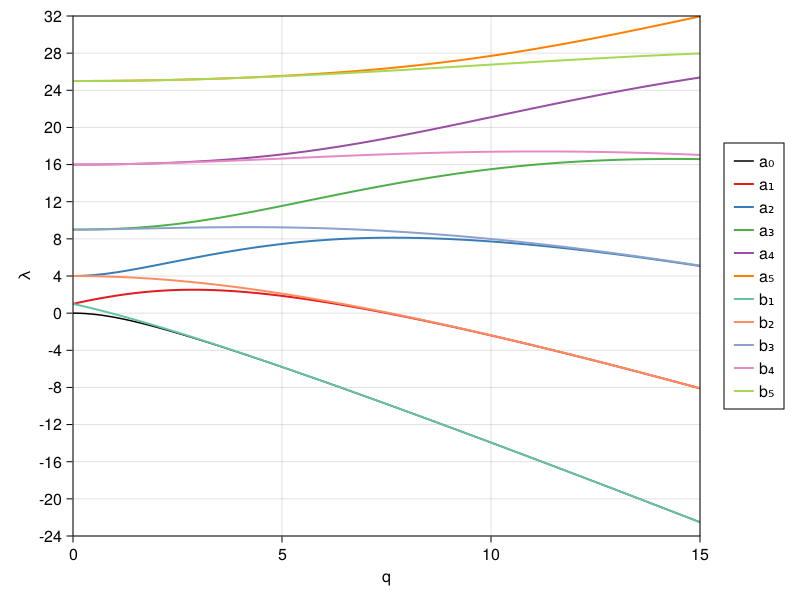

In [3]:
using CairoMakie
fig = Figure()
ax = Axis(fig[1,1], xlabel="q", ylabel="λ", yticks=-24:4:32)
lines!(q, data[1,:], color=:black, label="a₀")
series!(q, data[3:2:end, :], color=:Set1, labels=["a"*Char(Int('₀')+n) for n in 1:5])
series!(q, data[2:2:end, :], color=:Set2, labels=["b"*Char(Int('₀')+n) for n in 1:5])
limits!(0, 15, -24, 32)
Legend(fig[1,2], ax)
fig

## Generalized eigenproblem

Next we look at an eigenvalue variant of the Airy equation,

$$
\partial_{xx}u = \lambda x u, \qquad u(-1)=u(1)=0. 
$$

The obvious discretization of the ODE is

$$
\bfD_{xx} \bfu = \lambda \operatorname{diagm}(x_0,\ldots,x_N) \bfu. 
$$

Given the boundary conditions, we should lop off the first and last row and column from the above. What's left is a **generalized eigenproblem** of the form $\bfA \bfu = \lambda \mathbf{M} \bfu$. If $\mathbf{M}$ is invertible, we can just look for ordinary eigenvalues of $\mathbf{M}^{-1}\bfA$, but since $0$ might be a grid point, it's best to solve it as posed above.

### p22: 5th eigenvector of Airy equation 

$$u_{xx} = \lambda x u, \qquad u(-1)=u(1)=0$$

In [4]:
xx = range(-1,1,301)
N = 12:12:48
VV = zeros(length(xx),length(N))
λλ = zeros(length(N))
for (j,N) in enumerate(N)
    D, x = cheb(N)
    D² = (D^2)[2:N, 2:N]
    λ, V = eigen(D², diagm(x[2:N]))      # generalized ev problem
    ii = findall(λ .> 0)[5]
    λλ[j] = λ[ii]
    v = [0; V[:, ii]; 0]
    p = polyinterp(x, v)
    VV[:,j] = normalize( sign(p(0)) * p.(xx), Inf )
end

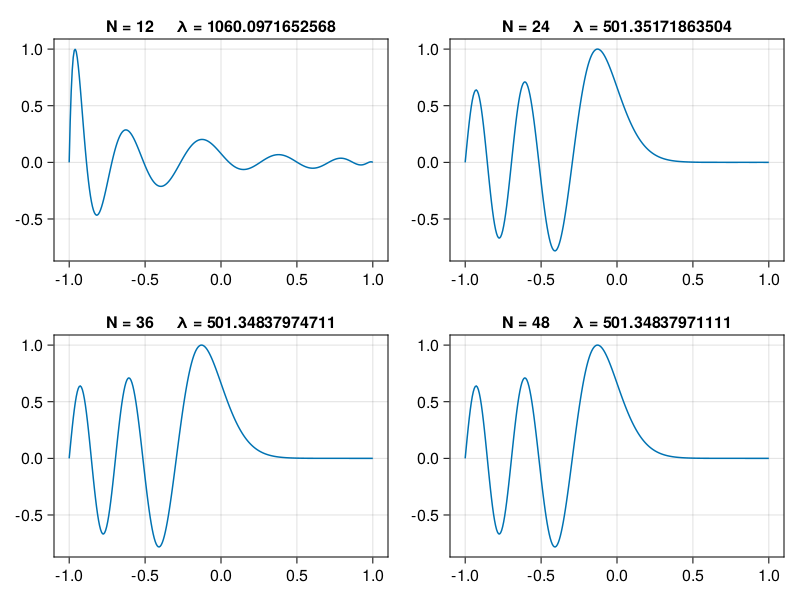

In [5]:
using PyFormattedStrings
fig = Figure()
ax = vec( [Axis(fig[j,i]) for i in 1:2, j in 1:2] )
for (j,ax) in enumerate(ax)
    lines!(ax,xx,VV[:,j])
    ax.title = f"N = {N[j]}     λ = {λλ[j]:.14g}"
end
linkyaxes!(ax...)
fig

## Neumann condition

We can also use a generalized eigenproblem to easily impose boundary conditions of types other than Dirichlet. Note that any boundary condition of a linear eigenvalue problem is necessarily homogeneous.

Suppose that $\bfA$ is the $(N+1)\times(N+1)$ discretization of an ODE over the entire grid. Let the boundary conditions be discretized as a $2\times(N+1)$ matrix $\bfB$, so that $\bfB \bfu = \bfzero$ must be imposed in place of the boundary rows of $\bfA$.  Then

$$
\begin{bmatrix}
  \bfC \bfA \\ \bfB
\end{bmatrix} \bfu = 
\lambda \begin{bmatrix}
  \bfC \bfI \\ \bfB
\end{bmatrix} \bfu = \mathbf{M} \bfu, 
$$

where $\bfC$ is the $(N-1)\times (N+1)$ matrix that chops off the first and last rows. We use this below to solve the eigenvalue problem

$$u_{xx} = \lambda u, \qquad u(-1)=0,\; u'(1)=0.$$

Rather than chopping off rows and then appending a boundary condition matrix, we just overwrite the boundary rows of $\bfA$ in place with the rows of $\bfB$. At the left end, it's a row of the identity matrix, and at the right, it's a row of $\bfD_x$.

In [6]:
N = 40
D, x = cheb(N)
A = -D^2
A[N+1,:] .= I(N+1)[N+1,:]  # Dirichlet at x = -1
A[1,:] .= D[1,:]           # Neumann at x = 1
M = diagm([0; ones(N-1); 0])
λ, V = eigen(A,M);
xx = range(-1,1,301)
VV = hcat( [polyinterp(x,v).(xx) for v in eachcol(V[:,1:20])]... );

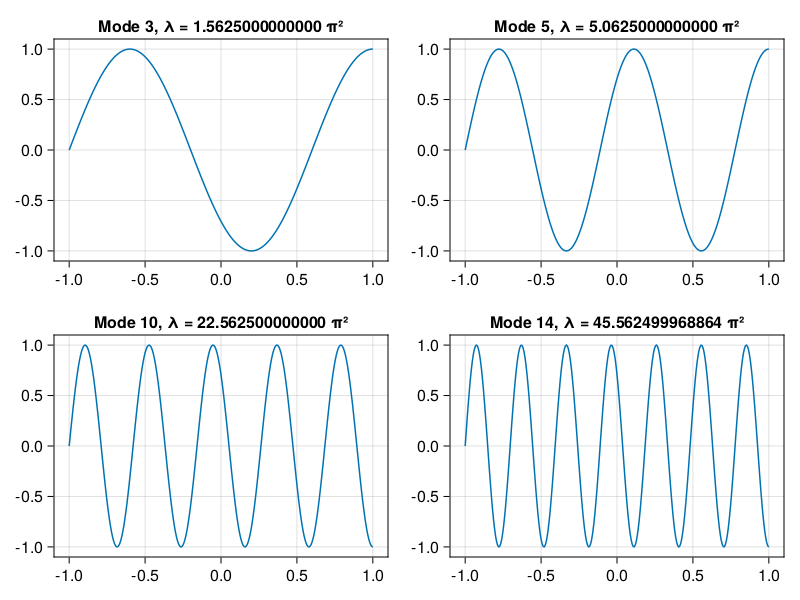

In [7]:
fig = Figure()
ax = vec( [Axis(fig[j,i]) for i in 1:2, j in 1:2] )
index = [3,5,10,14]
for (i,j) in enumerate(index)
    lines!(ax[i], xx, VV[:,j])
    ax[i].title = f"Mode {j}, λ = {λ[j]/π^2:#.14g} π²"
end
linkyaxes!(ax...)
fig